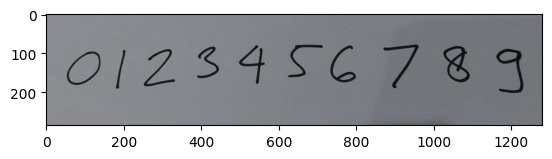

In [102]:
import cv2
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50


# PATH = 'images/numbers.jpg'
PATH = 'images/handwritten-numbers.jpg'

MODEL = 'resnet50.pth'

GREEN = (0, 255, 0)
THICKNESS = 2
FONT_SCALE = 1.5
RESNET_SIZE = 32 # pixel


def cv2_imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)


image = cv2.imread(PATH)
cv2_imshow(image)

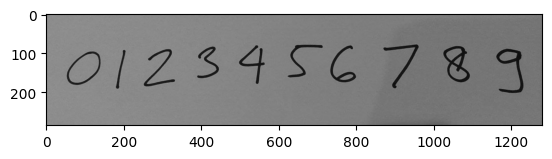

In [103]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

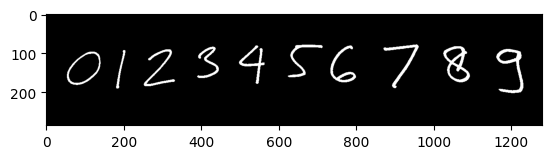

In [104]:
_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cv2_imshow(thresh)

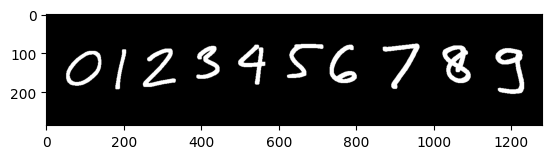

In [105]:
kernel = np.ones((3, 3), np.uint8)
dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel, iterations=2)
cv2_imshow(dilate)

chars: 10


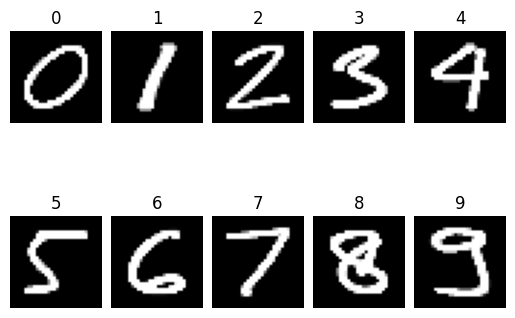

In [106]:
BLACK = (0, 0, 0)

contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sort_contours(contours, method='left-to-right')[0]

chars = []
for contour in contours:
    # extract x, y, width, height
    (x, y, w, h) = cv2.boundingRect(contour)

    if (w < 5 or w > 100):
        continue

    if (h < 15 or h > 120):
        continue

    roi = dilate[y:y+h, x:x+w]

    SIZE = 20

    padded = cv2.copyMakeBorder(
        roi, top=SIZE, bottom=SIZE, left=SIZE, right=SIZE,
        borderType=cv2.BORDER_CONSTANT, value=BLACK)

    padded = cv2.resize(padded, (32, 32))

    chars.append((padded, (x, y, w, h)))

print("chars:", len(chars))


def imshow(fig, img, title="", row=None, column=None, counter=None):
    if row and column and counter:
        fig.add_subplot(row, column, counter).set_title(title)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


fig = plt.figure()
fig.subplots_adjust(wspace=0.1, hspace=0)

for i, (img, bbox) in enumerate(chars):
    imshow(fig, img, i, 2, 5, i+1)

plt.show()

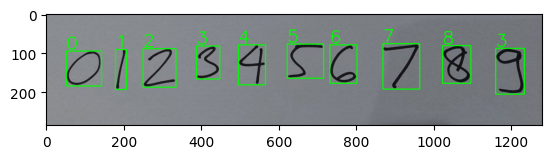

In [107]:
model = resnet50(num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2),
                        padding=(3, 3), bias=False)

model.load_state_dict(torch.load(MODEL))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((32, 32)),
])

with torch.no_grad():
    for i in range(len(chars)):
        roi = chars[i][0]
        (x, y, w, h) = chars[i][1]
        roi_tensor = transform(roi).unsqueeze(0)

        prediction = model(roi_tensor)

        _, predicted = torch.max(prediction.data, 1)

        result = str(predicted.item())

        cv2.rectangle(image, (x, y), (x+w, y+h), GREEN, THICKNESS)
        cv2.putText(image, result, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX,
                    FONT_SCALE, GREEN, THICKNESS)

cv2_imshow(image)